In [1]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

from DogDataset import DogDataset
from utils import *
from VAEModel import VariationalAutoencoder

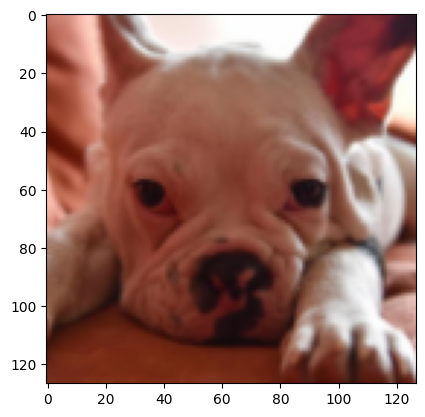

In [2]:
dog_dataset = DogDataset("./dog")
image = dog_dataset[1]
plt.imshow(out_to_image(image))

### Initializing the Model

In [3]:
latent_space_size = 256
model = VariationalAutoencoder(latent_space_size)

ex_in = dog_dataset[0]
ex_in = ex_in.unsqueeze(0)
ex_out, ex_mu, ex_logvar = model(ex_in)

ex_in.shape, ex_out.shape

(torch.Size([1, 3, 127, 127]), torch.Size([1, 3, 127, 127]))

In [13]:
from torchsummary import summary

summary(model, dog_dataset[0].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 63, 63]           2,432
       BatchNorm2d-2           [-1, 32, 63, 63]              64
              ReLU-3           [-1, 32, 63, 63]               0
            Conv2d-4           [-1, 64, 31, 31]          51,264
       BatchNorm2d-5           [-1, 64, 31, 31]             128
              ReLU-6           [-1, 64, 31, 31]               0
            Conv2d-7          [-1, 128, 15, 15]         204,928
       BatchNorm2d-8          [-1, 128, 15, 15]             256
              ReLU-9          [-1, 128, 15, 15]               0
           Conv2d-10            [-1, 128, 7, 7]         409,728
      BatchNorm2d-11            [-1, 128, 7, 7]             256
             ReLU-12            [-1, 128, 7, 7]               0
           Conv2d-13            [-1, 128, 3, 3]         409,728
      BatchNorm2d-14            [-1, 12

In [4]:
!export CUDA_VISIBLE_DEVICES=6

In [5]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Training the Model (Skip this section if not training)

In [8]:
batch_size = 128

dataloader = DataLoader(dog_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
recon_loss_criterion = nn.MSELoss()
kld_weight = 0.00025

losses = []
num_epochs = 700
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for dog_images in dataloader:
        optimizer.zero_grad()

        dog_images = dog_images.to(device)
        output, mu, log_var = model(dog_images)

        recon_loss = recon_loss_criterion(dog_images, output)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        total_loss = recon_loss + kld_weight * kld_loss
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()
    running_loss /= len(dataloader)
    losses.append(running_loss)
    

100%|██████████| 700/700 [6:35:45<00:00, 33.92s/it]  


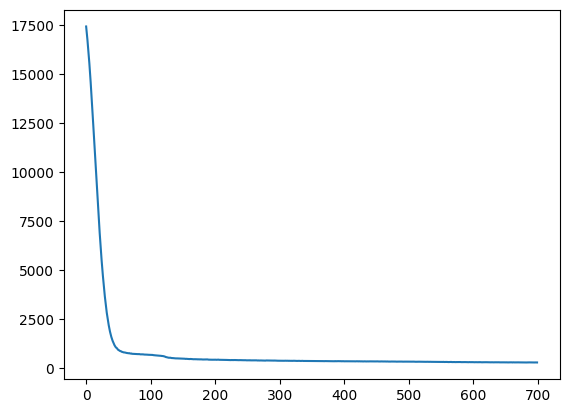

In [9]:
plt.plot(range(len(losses)), losses)

In [10]:
torch.save(model.state_dict(), f"./output_models/output_{latent_space_size}_{num_epochs}.pth")

### Generating Images

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("./output_models/output_256_700.pth"))
model = model.to(device)

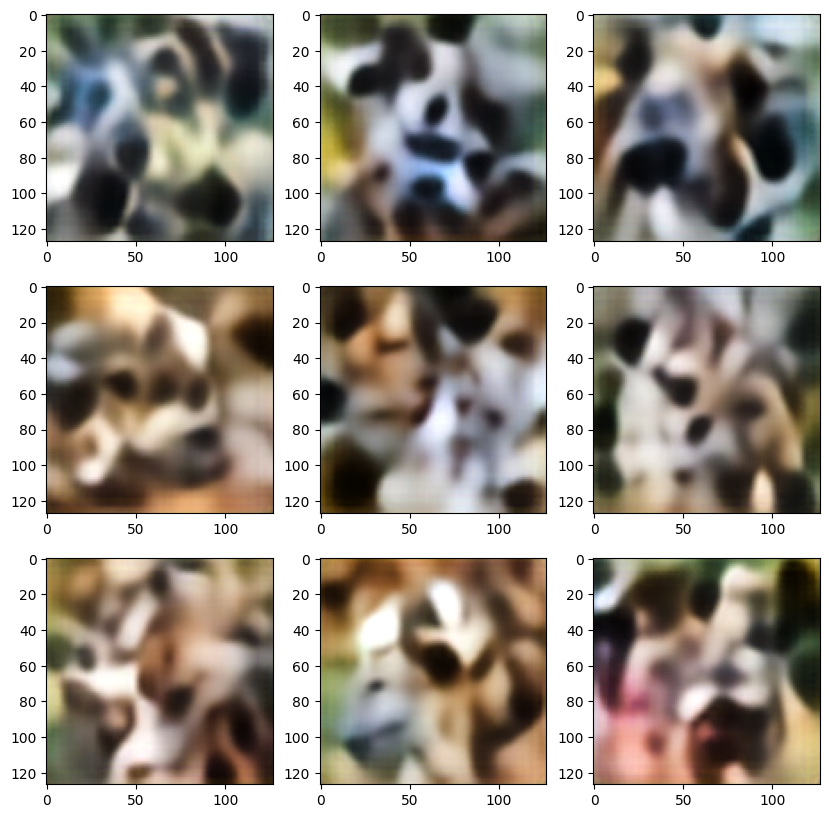

In [7]:
# Randomly sample from the latent dimension and decode
z = torch.randn(9, model.latent_dim)
z = z.to(device)

samples = model.decode(z)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(out_to_image(samples[i].detach().cpu()))

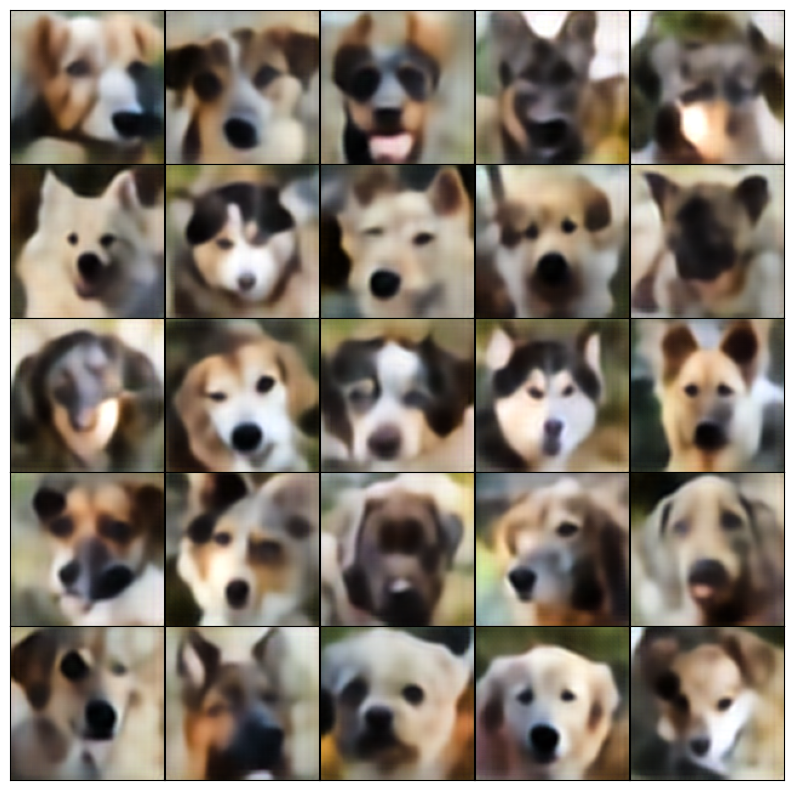

In [9]:
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    idx = random.randrange(0, len(dog_dataset))
    image = dog_dataset[idx]

    image = image.to(device)
    model_out = model(image.unsqueeze(0))[0][0]
    
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(out_to_image(model_out.detach().cpu()))

plt.subplots_adjust(wspace=0, hspace=0)